In [11]:
import networkx as nx
import ConfigModel_MCMC as CM
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [12]:
def add_gender_metadata(gender_filename, G):
    f = open(gender_filename, "r")
    allLines = f.readlines()
    
    for i in range(len(allLines)):
        list_of_entries = allLines[i].strip()
        list_of_entries = list_of_entries.split(" ")    
        if list_of_entries[0] == '1':
            G.nodes[i]["gender"] = "Female"
        else:
            G.nodes[i]["gender"] = "Male"
            
def get_adjacency_matrix(allLines):
    adjacency_matrix = [[0 for i in range(len(allLines))] for j in range(len(allLines))]

    for i in range(len(allLines)):
        list_of_entries = allLines[i].strip()
        list_of_entries = list_of_entries.split(" ")
        for j in range(0, len(list_of_entries)):
            if i != j and list_of_entries[j] == '1':
                adjacency_matrix[i][j] = 1
                
    return adjacency_matrix

def initialise_friendshipGraph():
    gender_filename = "HighSchoolMetadata23.DAT"
    
    f = open(gender_filename, "r")
    allLines = f.readlines()
    numnodes = len(allLines)
    friendship_G = nx.Graph()
    for node in range(numnodes):
        friendship_G.add_node(node)          
        
    add_gender_metadata(gender_filename, friendship_G)
    
    f = open("HighSchoolLinkMatrix23.DAT", "r")
    
    allLines = f.readlines()
    adjacency_matrix = get_adjacency_matrix(allLines)
            
    for i in range(len(allLines)):
        for j in range(len(allLines)):
            if adjacency_matrix[i][j] == 1 and adjacency_matrix[j][i] == 1:
                friendship_G.add_edge(i, j)

    # So in this network, BOTH nodes have said that they give/receive emotional support from the other. Good!
                
    return friendship_G

In [13]:
from scipy.interpolate import make_interp_spline
from scipy.ndimage.filters import gaussian_filter1d

def get_smooth_curves(x, y, nums):
    f = interp1d(x, y, kind='cubic')
    xnew = np.linspace(min(x), max(x), num=nums, endpoint=True)
    ysmoothed = gaussian_filter1d(y, sigma=1.8)

    new_smooth = []
    return_xnew = []
    list_xnew = list(xnew)
    baseline = []
    i = 0
    
    for each in f(xnew):
        new_smooth.append(each)
        return_xnew.append(list_xnew[i])
        baseline.append(0.5)
        i+=1

    return return_xnew, ysmoothed ,baseline #new_smooth
    
def get_null_distribution():
    friendship_G = initialise_friendshipGraph()
    allow_loops = False
    allow_multi = False
    is_vertex_labeled = True
    mcmc_object = CM.MCMC(friendship_G, allow_loops, allow_multi, is_vertex_labeled)

    ref_gender_assortativity = []
    for i in range(1000):
        G_new = mcmc_object.get_graph()
        gender_filename = "HighSchoolMetadata23.DAT"
        add_gender_metadata(gender_filename, G_new)
        ref_gender_assortativity.append(nx.attribute_assortativity_coefficient(G_new, "gender"))

    return friendship_G, ref_gender_assortativity

/var/folders/2g/tc1fbnhj17g_6hj3z0hkc7pr0000gn/T/ipykernel_9966/2850164175.py:2: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [16]:
def get_plot_with_null_distribution(metadata): # School number 23
    # Note, the get_null_distribution() function generates networks stochastically. 
    # Hence, the value of 'nums' variable should be changed accordingly.
    nums = 21
    friendship_G, ref_gender_assortativity = get_null_distribution()
    print("Number of nodes = ", friendship_G.number_of_nodes())
    print("Number of edges = ", friendship_G.number_of_edges())
    y, x, i = plt.hist(ref_gender_assortativity, bins=nums)

    actualAssort = nx.attribute_assortativity_coefficient(friendship_G, metadata)
    print("actualAssort = ", actualAssort)
    plt.axvline(actualAssort, c = "r", lw = 3)

    X = x[:-1]
    Y = y

    plt.figure(figsize=(10,5))

    emp = actualAssort # For school no. 23

    m_4 = get_smooth_curves(X, Y, nums=nums)
    plt.plot(m_4[0], np.array(m_4[1])/sum(m_4[1]), 'c-', alpha=1, lw = 3, label = "Reference distribution")  
        
    plt.fill_between(m_4[0], np.array(m_4[1])/sum(m_4[1]), 0, color='grey', alpha=0.2)          # Transparency of the fill

    plt.axvline(emp,c='y',label="Observed value",lw=4,linestyle="--")

    plt.xlabel("Gender assortativity",fontsize = 20, color = 'black')
    plt.ylabel('Density', fontsize = 20, color = 'black')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.ylim(0.007, 0.17)
    plt.legend(fontsize=18, loc="upper left", ncol=1,handleheight=2.4, labelspacing=0.05)
    
    plt.show()

Number of nodes =  73
Number of edges =  51
actualAssort =  0.7352941176470588


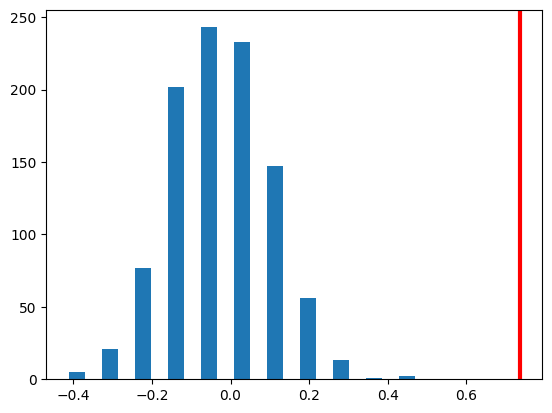

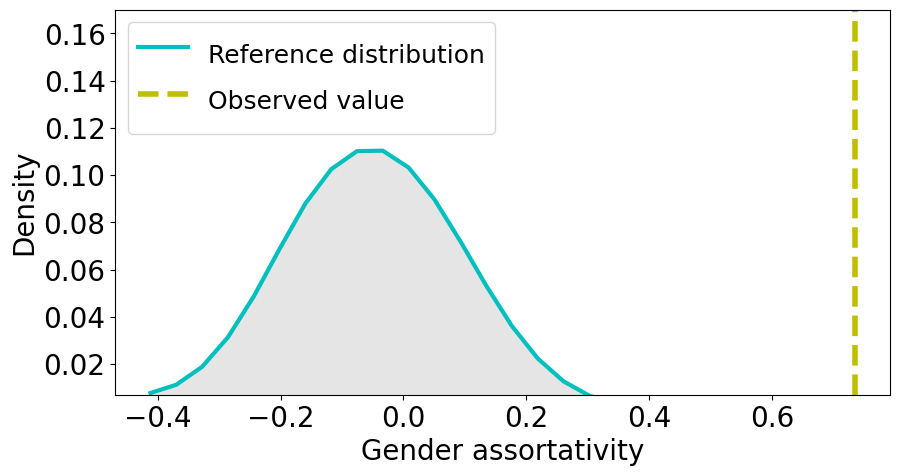

In [18]:
get_plot_with_null_distribution(metadata = "gender")